In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale
from skimage.transform import iradon
import cv2 as cv

In [2]:
original_image = cv.imread('test1.png', 0)
image = cv.resize(original_image, (568, 568))
image = image+np.random.normal(0, 1, size=(568, 568))
image = rescale(image, scale=0.4, mode='reflect')

In [3]:
def radon_transform(image, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
    ax1.set_title("Original")
    ax1.imshow(image, cmap=plt.cm.Greys_r)

    theta = np.linspace(0., 180., max(image.shape), endpoint=False)
    sinogram = radon(image, theta=theta)
    dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
    ax2.set_title(title)
    ax2.set_xlabel("Projection angle (deg)")
    ax2.set_ylabel("Projection position (pixels)")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
               extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
               aspect='auto')

    fig.tight_layout()
    plt.show()
    
    return sinogram

In [4]:
def inv_radon(image, sinogram, title):
    theta = np.linspace(0., 180., max(image.shape), endpoint=False)
    reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
    error = reconstruction_fbp - image
    print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

    imkwargs = dict(vmin=-0.2, vmax=0.2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                                   sharex=True, sharey=True)
    ax1.set_title("Reconstruction\nFiltered back projection")
    ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
    ax2.set_title("Reconstruction error\nFiltered back projection")
    ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
    plt.show()
    
    return reconstruction_fbp

In [5]:
def cluster_radon(sinogram, ext=6):
    H, W = sinogram.shape[0], sinogram.shape[1]
    res = np.zeros((H, W))
    cumsum = np.cumsum(sinogram, 0)
    eps = 1e-6
    mid = W//2
    for i in range(0, H):
        idx = min(i+5, H-1)
        numer = abs((cumsum[idx, :mid]-cumsum[i, :mid])-(cumsum[idx, -mid:]-cumsum[i, -mid:]))
        deno = (cumsum[idx, :mid]-cumsum[i, :mid])+(cumsum[idx, -mid:]-cumsum[i, -mid:])
        res[i, :mid] = 1- (numer/(deno+eps))
        res[i, -mid:] = 1- (numer/(deno+eps))
    return res

In [6]:
def just_plot(image_mats, dim, size):
    nums = len(image_mats)
    plt.figure(figsize=size)
    for i in range(nums):
        plt.subplot(1, nums, i+1)
        plt.imshow(image_mats[i], cmap=plt.cm.Greys_r)
    plt.show()

In [7]:
def contrast_stretch(image):
    max_int = np.max(np.max(image, 0))
    min_int = np.min(np.min(image, 0))
    image = 255*(image-min_int)/(max_int-min_int)
    return np.uint8(image)

In [71]:
def line_selection(lines, min_dist=20):
    from scipy import ndimage as ndi
    from skimage.feature import peak_local_max
    from skimage import img_as_float
    h, w = lines.shape[0], lines.shape[1]
    res = np.zeros((h, w))
    im_float = img_as_float(lines)
    image_max = ndi.maximum_filter(im_float, size=min_dist, mode='constant')
    coordinates = peak_local_max(im_float, min_distance=min_dist)
    res[coordinates[:, 0], coordinates[:, 1]]=255
    return res

/media/lalit/Lalit/Environments/dl-env/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


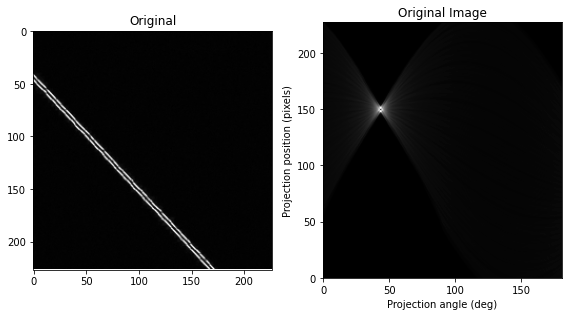

FBP rms reconstruction error: 5.35


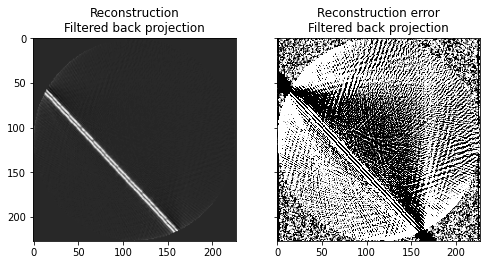

In [9]:
sino_orig = radon_transform(image, "Original Image")
inv_image = inv_radon(image, sino_orig, "Normal Inverse")

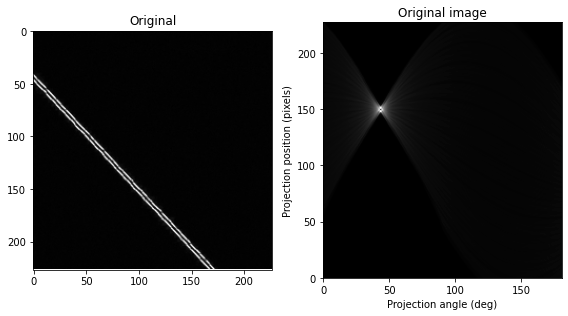

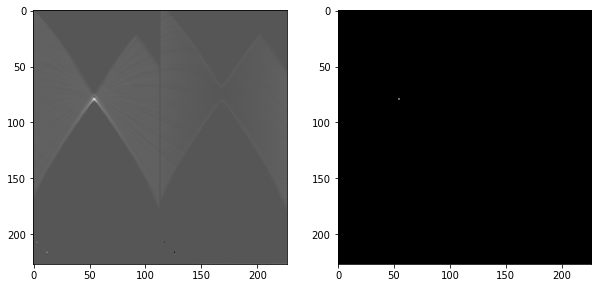

FBP rms reconstruction error: 10.8


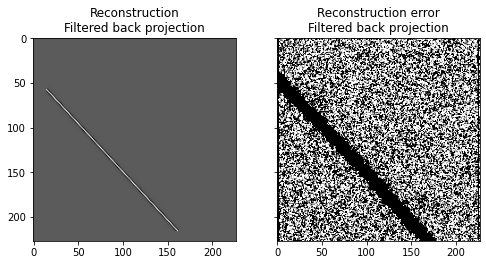

In [10]:
sino_orig_2 = radon_transform(image, "Original image")
clustered = cluster_radon(sino_orig_2, 10)

sino_clust = sino_orig_2*clustered
max_val = np.max(np.max(sino_clust, 0))
threshed = sino_clust*(sino_clust<=max_val)*(sino_clust>0.9*max_val)

just_plot([sino_clust, threshed], (1, 2), (10, 10))
inv_clusterd = inv_radon(image, threshed, "Clustered image only")

In [78]:
new_image = cv.imread('Test1_images/5.jpg', 0)
mind = min(new_image.shape[0], new_image.shape[1])
image2 = cv.resize(new_image, (mind, mind))
# image = image+np.random.normal(0, 1, size=(568, 568))
image2 = rescale(image2, scale=0.5, mode='reflect')

In [79]:
image2 = contrast_stretch(image2)

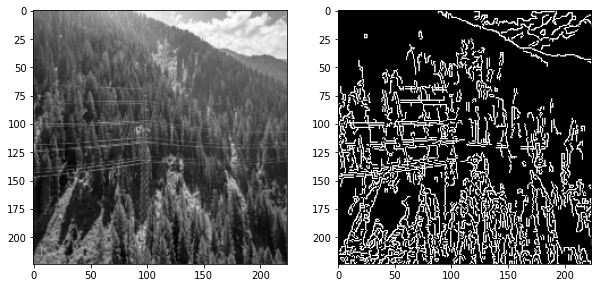

In [80]:
bil_filtered = cv.bilateralFilter(image2, 15, 1000, 0.001)
edges = cv.Canny(bil_filtered, 100, 200)
just_plot([bil_filtered, edges], (1, 2), (10, 8))

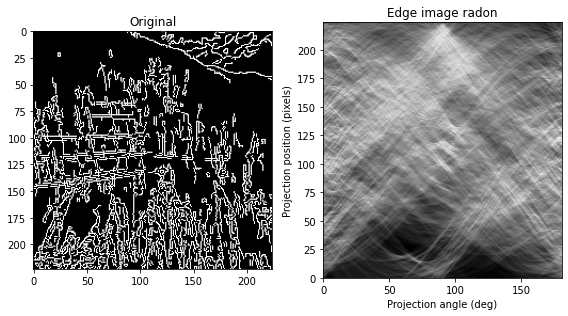

In [81]:
sino_test = radon_transform(edges, "Edge image radon")

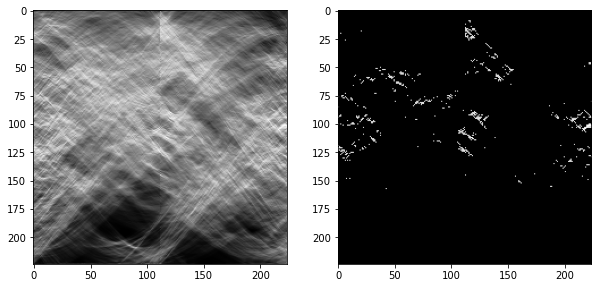

FBP rms reconstruction error: 109


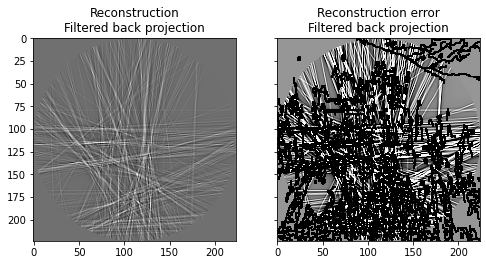

In [82]:
clustered_test = cluster_radon(sino_test, 10)

sino_test_clust = sino_test*clustered_test
max_val = np.max(np.max(sino_test_clust, 0))
threshed2 = sino_test_clust*(sino_test_clust>0.7*max_val)

just_plot([sino_test_clust, threshed2], (1, 2), (10, 10))
inv_clusterd_test = inv_radon(edges, threshed2, "Clustered image only")

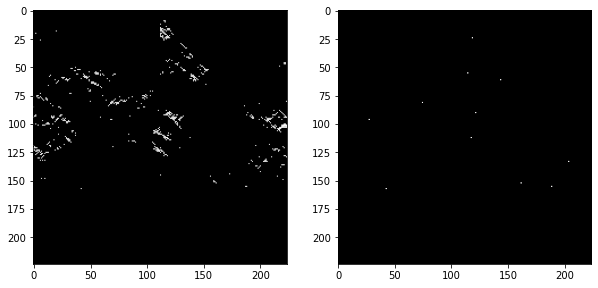

FBP rms reconstruction error: 109


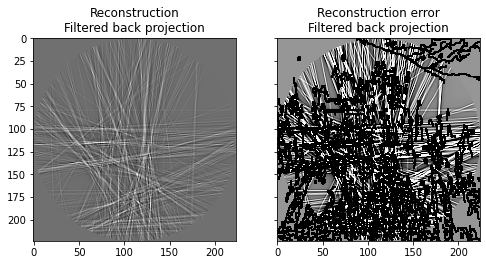

FBP rms reconstruction error: 109


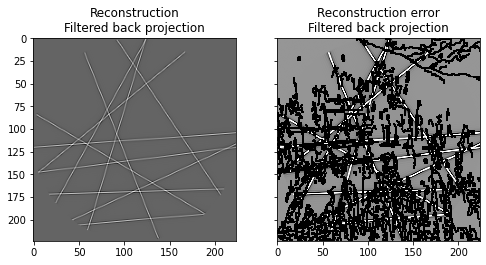

In [83]:
after_selection = line_selection(threshed2, 20)
just_plot([threshed2, after_selection], (1, 2), (10, 8))
inv_clusterd_test = inv_radon(edges, threshed2, "Clustered image only")
inv_clusterd_test_sel = inv_radon(edges, after_selection, "Clustered image only")

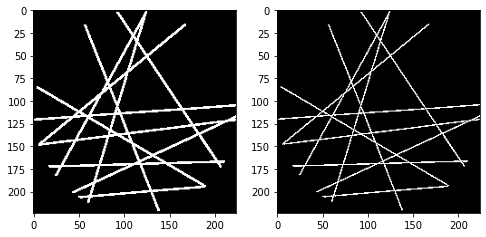

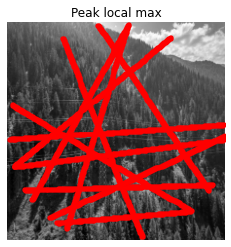

In [84]:
kernel = np.ones((2, 2), np.uint8)
ret, thresh = cv.threshold(inv_clusterd_test_sel, 0, 255, cv.THRESH_BINARY)
img_dilation = cv.dilate(thresh, kernel, iterations=1)
just_plot([img_dilation, thresh], (1, 2), (8, 10))
coordis = []

for i in range(img_dilation.shape[0]):
    for j in range(img_dilation.shape[1]):
        if img_dilation[i, j]==255:
            coordis.append((i, j))

coordis = np.array(coordis)

plt.figure()
plt.imshow(image2, cmap=plt.cm.gray)
plt.autoscale(False)
plt.plot(coordis[:, 1], coordis[:, 0], 'r.')
plt.axis('off')
plt.title('Peak local max')
plt.show()

In [18]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import img_as_float

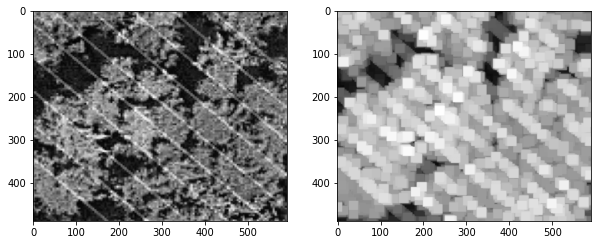

In [19]:
im_float = img_as_float(new_image)
image_max = ndi.maximum_filter(im_float, size=20, mode='constant')
coordinates = peak_local_max(im_float, min_distance=20)
just_plot([im_float, image_max], (1, 2), (10, 10))

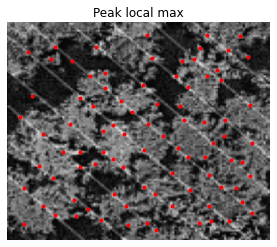

In [20]:
plt.figure()
plt.imshow(im_float, cmap=plt.cm.gray)
plt.autoscale(False)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.axis('off')
plt.title('Peak local max')
plt.show()

In [21]:
def detect_lines(image):
    h, w = image.shape[0], image.shape[1]
    mind = min(h, w)
    image_resized = cv.resize(image, (mind, mind))
    image_resized = rescale(image_resized, scale=0.4, mode='reflect')
    image_contrast = contrast_stretch(image_resized)
    bil_filtered = cv.bilateralFilter(image_contrast, 15, 1000, 0.001)
    edges = cv.Canny(bil_filtered, 100, 200)
    
    sinogram = radon_transform(edges, "")
    clustered = cluster_radon(sinogram, 10)
    sinogram_clust = sinogram*clustered
    max_val = np.max(np.max(sinogram_clust, 0))
    threshed = 255*(sinogram_clust > 0.7*max_val)
    select_lines = line_selection(threshed, 25, 1, 1)
    inv_sino = inv_radon(edges, select_lines, "")
    
    kernel = np.ones((2, 2), np.uint8)
    _, binthresh = cv.threshold(inv_sino, 0, 255, cv.THRESH_BINARY)
    image_dilation = cv.dilate(binthresh, kernel, iterations=1)
    coordis = []
    for i in range(image_dilation.shape[0]):
        for j in range(image_dilation.shape[1]):
            if image_dilation[i, j]==255:
                coordis.append((i, j))
    coordis = np.array(coordis)
    return coordis

In [22]:
image_read = cv.imread("test3.png", 0)

In [23]:
image_read.shape

(489, 591)

/media/lalit/Lalit/Environments/dl-env/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


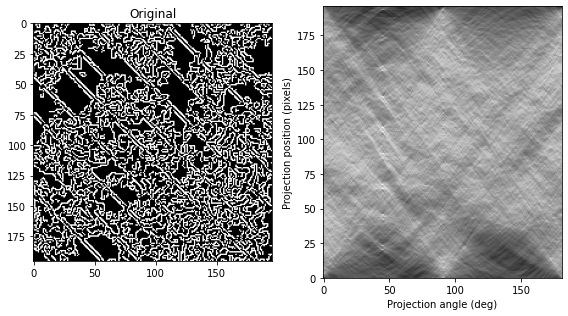

FBP rms reconstruction error: 143


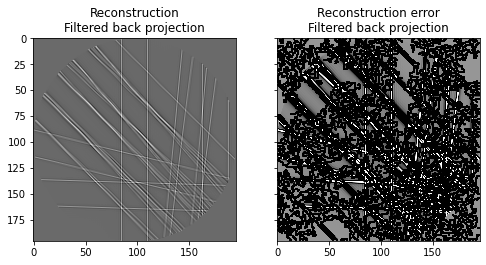

(10351, 2)


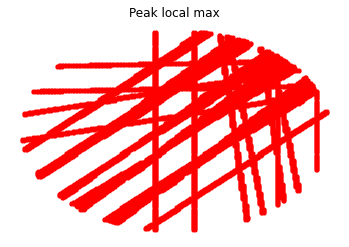

In [24]:
coordis = detect_lines(image_read)
print(coordis.shape)
plt.figure()
plt.plot(coordis[:, 1], coordis[:, 0], 'r.')
plt.axis('off')
plt.title('Peak local max')
plt.show()


/media/lalit/Lalit/Environments/dl-env/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


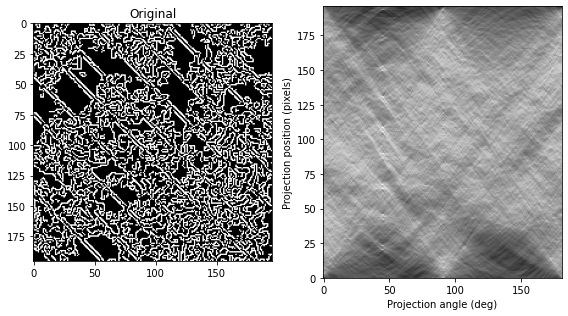

FBP rms reconstruction error: 143


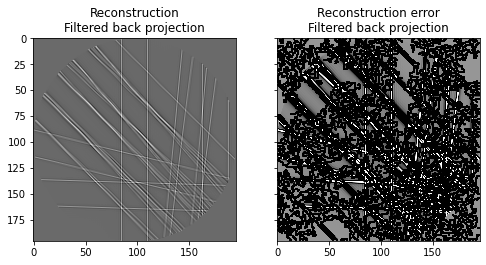

(10351, 2)


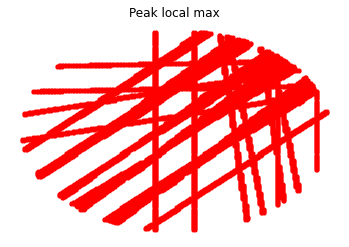

In [25]:
coordis = detect_lines(image_read)
print(coordis.shape)
plt.figure()
plt.plot(coordis[:, 1], coordis[:, 0], 'r.')
plt.axis('off')
plt.title('Peak local max')
plt.show()